# Chapter 4 - Logistic Regression

This notebook presents the Python implementation of exercises from the book *"Introduction to Statistical Learning"* (a.k.a. ISLR) by Gareth James et al.

---

# Lab Exercises - Logistic Regression

## The Stock Market Data

**Dataset**: Smarket.csv; Daily percentage returns for the S&P 500 stock index between 2001 and 2005.

    
**Variables**: 1250 observations on the following 9 variables.

* Year: The year that the observation was recorded
* Lag1: Percentage return for previous day
* Lag2: Percentage return for 2 days previous
* Lag3: Percentage return for 3 days previous
* Lag4: Percentage return for 4 days previous
* Lag5: Percentage return for 5 days previous
* Volume: Volume of shares traded (number of daily shares traded in billions)
* Today: Percentage return for today
* Direction: A factor with levels Down and Up indicating whether the market had a positive or negative return on a given day

In [284]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_style('whitegrid')
sns.set_palette('RdBu')

%matplotlib inline

In [266]:
# Import data
smarket = pd.read_csv('data/ISLR/Smarket.csv', index_col=0)

# Briefly explore the data
smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


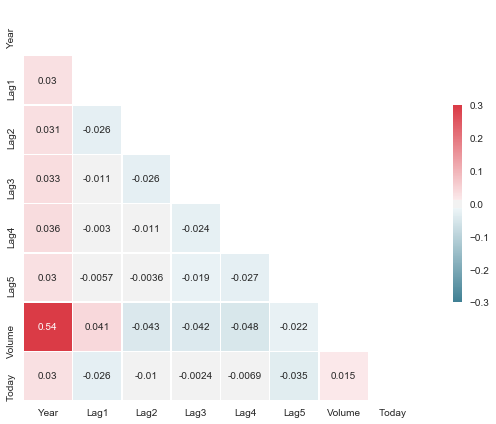

In [267]:
# Generate and visualize the correlation matrix for quantitative variables
corr = smarket.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.tight_layout()

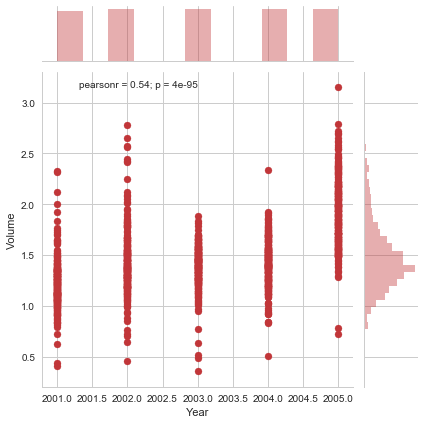

In [268]:
plt.figure(figsize=(10,6))
sns.jointplot(x='Year', y='Volume', data=smarket)

## Logistic Regression

Fit a logistic regression model to predict *Direction* using *Lag1* through *Lag5* and *Volume*.

In [269]:
formula = 'Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
model = smf.glm(formula=formula, data=smarket, family=sm.families.Binomial())
logistic_fit = model.fit()

print(logistic_fit.summary())

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1250
Model:                                              GLM   Df Residuals:                     1243
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                             1.0
Method:                                            IRLS   Log-Likelihood:                -863.79
Date:                                  Thu, 05 Oct 2017   Deviance:                       1727.6
Time:                                          19:41:19   Pearson chi2:                 1.25e+03
No. Iterations:                                       4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [270]:
predictions = logistic_fit.predict()
print(predictions[0:10])

[ 0.49  0.52  0.52  0.48  0.49  0.49  0.51  0.49  0.48  0.51]


In [271]:
print(np.column_stack((smarket.as_matrix(columns = ["Direction"]).flatten(), logistic_fit.model.endog)))

[['Up' 0.0]
 ['Up' 0.0]
 ['Down' 1.0]
 ..., 
 ['Up' 0.0]
 ['Down' 1.0]
 ['Down' 1.0]]


In [272]:
predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]
print(classification_report(smarket['Direction'], predictions_nominal, digits=3))
cfm = confusion_matrix(smarket['Direction'], predictions_nominal)

true_negative = cfm[0][0]
false_positive = cfm[0][1]
false_negative = cfm[1][0]
true_positive = cfm[1][1]

print('Confusion Matrix: \n', cfm, '\n')

print('True Negative:', true_negative)
print('False Positive:', false_positive)
print('False Negative:', false_negative)
print('True Positive:', true_positive)
print('Correct Predictions', round((true_negative + true_positive) / len(predictions_nominal) * 100, 1), '%')

             precision    recall  f1-score   support

       Down      0.507     0.241     0.327       602
         Up      0.526     0.782     0.629       648

avg / total      0.517     0.522     0.483      1250

Confusion Matrix: 
 [[145 457]
 [141 507]] 

True Negative: 145
False Positive: 457
False Negative: 141
True Positive: 507
Correct Predictions 52.2 %


The training error rate, 100 - 52.2 = 47.8% is overly optimistic because the model has been trained and tested on the same set of 1250 observations. To better assess the accurary of the logit model, we can try fitting the model to a part of the data.

To implement this strategy, use the data from years 2001-2004 as the training data, and use the 2005 data for prediction.

In [273]:
x_train = smarket[smarket['Year'] < 2005]
y_train = smarket[smarket['Year'] < 2005]['Direction']

x_test = smarket[smarket['Year'] == 2005]
y_test = smarket[smarket['Year'] == 2005]['Direction']

In [274]:
model = smf.glm(formula=formula, data=x_train, family=sm.families.Binomial())
logistic_fit2 = model.fit()

In [275]:
predictions = logistic_fit2.predict(x_test)
predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]

In [276]:
print(classification_report(y_test, predictions_nominal, digits=3))

cfm = confusion_matrix(y_test, predictions_nominal)

true_negative = cfm[0][0]
false_positive = cfm[0][1]
false_negative = cfm[1][0]
true_positive = cfm[1][1]

print('Confusion Matrix: \n', cfm, '\n')

print('True Negative:', true_negative)
print('False Positive:', false_positive)
print('False Negative:', false_negative)
print('True Positive:', true_positive)
print('Correct Predictions', round((true_negative + true_positive) / len(predictions_nominal) * 100, 1), '%')

             precision    recall  f1-score   support

       Down      0.443     0.694     0.540       111
         Up      0.564     0.312     0.402       141

avg / total      0.511     0.480     0.463       252

Confusion Matrix: 
 [[77 34]
 [97 44]] 

True Negative: 77
False Positive: 34
False Negative: 97
True Positive: 44
Correct Predictions 48.0 %


The test error rate, 1 - recall = 52% is actually worse than random guessing. This result is in fact not abnormal since one is generally not expected to be able to use past returns to predict future market performance.

Perhaps by removing some of the predictors, we should be able to obtain a more effective model. Below is a new model that uses only *Lag1* and *Lag2* as the predictors.

In [277]:
formula = 'Direction ~ Lag1 + Lag2'
model = smf.glm(formula=formula, data=x_train, family=sm.families.Binomial())
logistic_fit3 = model.fit()

print(logistic_fit3.summary())

predictions = logistic_fit3.predict(x_test)
predictions_nominal = [ "Up" if x < 0.5 else "Down" for x in predictions]

                          Generalized Linear Model Regression Results                           
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                  998
Model:                                              GLM   Df Residuals:                      995
Model Family:                                  Binomial   Df Model:                            2
Link Function:                                    logit   Scale:                             1.0
Method:                                            IRLS   Log-Likelihood:                -690.70
Date:                                  Thu, 05 Oct 2017   Deviance:                       1381.4
Time:                                          19:41:22   Pearson chi2:                     998.
No. Iterations:                                       4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [278]:
print(classification_report(y_test, predictions_nominal, digits=3))

cfm = confusion_matrix(y_test, predictions_nominal)

true_negative = cfm[0][0]
false_positive = cfm[0][1]
false_negative = cfm[1][0]
true_positive = cfm[1][1]

print('Confusion Matrix: \n', cfm, '\n')

print('True Negative:', true_negative)
print('False Positive:', false_positive)
print('False Negative:', false_negative)
print('True Positive:', true_positive)
print('Correct Predictions', round((true_negative + true_positive) / len(predictions_nominal) * 100, 1), '%')

             precision    recall  f1-score   support

       Down      0.500     0.315     0.387       111
         Up      0.582     0.752     0.656       141

avg / total      0.546     0.560     0.538       252

Confusion Matrix: 
 [[ 35  76]
 [ 35 106]] 

True Negative: 35
False Positive: 76
False Negative: 35
True Positive: 106
Correct Predictions 56.0 %


The results appear to be a little better now. 56% of the daily movements have been correctly predicted. However, the confusion matrix shows that on days when the model predicts an increase in the market, it has a 58% accuracy rate. This suggests a possible trading strategy that buys on days when the model predicts an increase in the market, and avoiding trades on days when a decrease is predicted. 

In [283]:
print('Accuracy | Predicted Positive (increase in market):', round(106 / (106 + 76) * 100, 1), '%')

Accuracy | Predicted Positive (increase in market): 58.2 %


---
### References:

ISLR-python: http://nbviewer.jupyter.org/github/JWarmenhoven/ISL-python/blob/master/Notebooks/Chapter%203.ipynb